# Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Load the data

In [ ]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

# Understand The data

In [ ]:
print(train_df.sample(5))

                                      filename      category
762    result_table_img_63345_0_1698336306.jpg    borderless
93     result_table_img_84368_0_1706812523.jpg      bordered
49      result_table_img_4310_0_1651001574.jpg      bordered
165   result_table_img_100896_0_1711553224.jpg      bordered
1187   result_table_img_16089_3_1671494101.jpg  row_bordered


In [ ]:
print(test_df.sample(5))

                                     filename      category
22              Ikea_-_Southlake_TX_-_Sta.png      bordered
55    result_table_img_77085_2_1704734504.jpg      bordered
112   result_table_img_71138_0_1701727928.jpg    borderless
200   result_table_img_76033_0_1704227510.jpg  row_bordered
74   result_table_img_106674_0_1712940255.jpg      bordered


# Preprocess the data

## Define image size and batch size

In [ ]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

## ImageDataGenerator for training and validation

In [ ]:
!unzip -q /content/train.zip -d /content/unzipped_folder


[/content/train.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/train.zip or
        /content/train.zip.zip, and cannot find /content/train.zip.ZIP, period.


In [ ]:
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_dataframe(
    train_df,
    directory='/content/unzipped_folder/train',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = datagen.flow_from_dataframe(
    train_df,
    directory='/content/unzipped_folder/train',
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1006 validated image filenames belonging to 3 classes.
Found 251 validated image filenames belonging to 3 classes.


# Build the model using a pre-trained VGG16

In [ ]:
num_classes = len(train_generator.class_indices)

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


# Train the model

In [ ]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10
32/32 [==============================] - 2053s 64s/step - loss: 1.7048 - accuracy: 0.4175 - val_loss: 1.1575 - val_accuracy: 0.0000e+00
Epoch 2/10
32/32 [==============================] - 1983s 62s/step - loss: 1.1041 - accuracy: 0.4761 - val_loss: 1.2748 - val_accuracy: 0.0000e+00
Epoch 3/10
32/32 [==============================] - 1952s 61s/step - loss: 1.0604 - accuracy: 0.4930 - val_loss: 1.1740 - val_accuracy: 0.0000e+00
Epoch 4/10
32/32 [==============================] - 1949s 61s/step - loss: 1.0610 - accuracy: 0.4970 - val_loss: 1.2564 - val_accuracy: 0.0000e+00
Epoch 5/10
32/32 [==============================] - 1982s 62s/step - loss: 1.0466 - accuracy: 0.4970 - val_loss: 1.3244 - val_accuracy: 0.0000e+00
Epoch 6/10
32/32 [==============================] - 1943s 61s/step - loss: 1.0427 - accuracy: 0.4970 - val_loss: 1.3707 - val_accuracy: 0.0000e+00
Epoch 7/10
32/32 [==============================] - 1942s 61s/step - loss: 1.0425 - accuracy: 0.4970 - val_loss: 1.391

# Evaluate the model on test data

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory='/content/unzipped_folder/test',
    x_col='filename',
    y_col=None,
    target_size=IMAGE_SIZE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)


Found 300 validated image filenames.
300/300 [==============================] - 189s 627ms/step


# Map predictions to class labels

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predicted_labels = [labels[k] for k in predicted_classes]

# Save predictions to the CSV file

In [ ]:
test_df['category'] = predicted_labels
test_df.to_csv('predictions.csv', index=False)

# Print classification report

In [ ]:
print(classification_report(test_df['category'], predicted_labels))


              precision    recall  f1-score   support

  borderless       1.00      1.00      1.00       300

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300



# Confusion matrix

In [ ]:
cm = confusion_matrix(test_df['category'], predicted_labels)

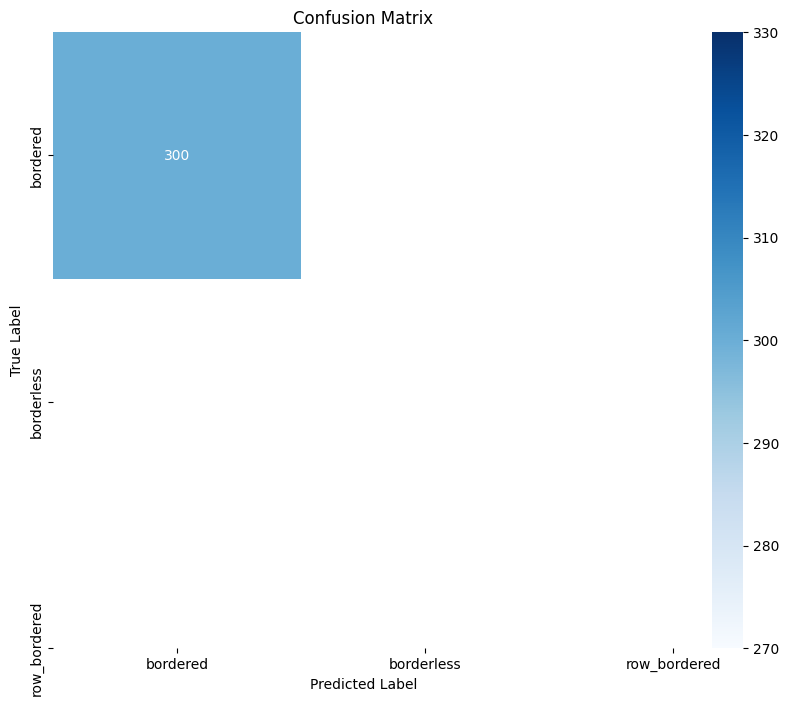

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels.values(), yticklabels=labels.values())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training history

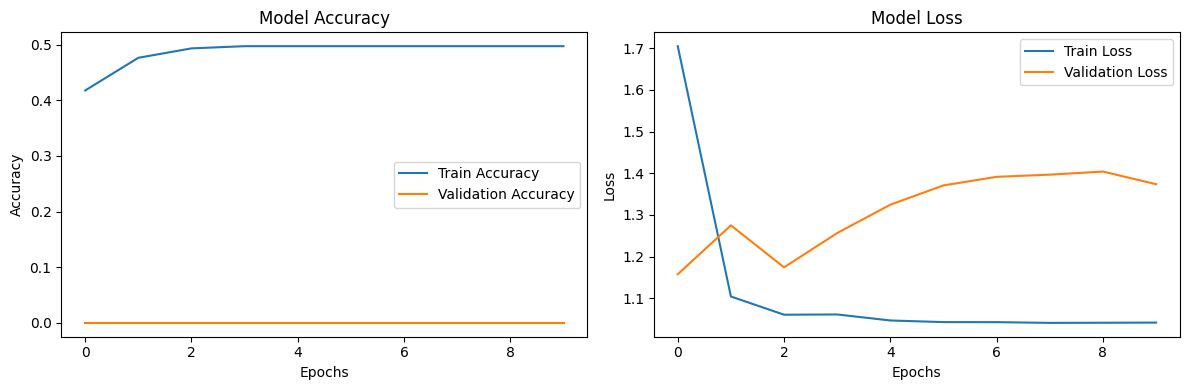

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Model Accuracy:**

**Training Accuracy:** The training accuracy improves over epochs, starting around 0.4 and reaching just above 0.5 by the end of the training.
**Validation Accuracy:** The validation accuracy remains at 0 throughout all epochs.
**Conclusion**: The model is learning on the training data, as indicated by the increase in training accuracy. However, it is not generalizing well to the validation data, which suggests overfitting. The model might be memorizing the training data without learning to generalize.



**Model Loss:**

**Training Loss:** The training loss decreases significantly in the first epoch and then stabilizes around a lower value.
**Validation Loss:** The validation loss starts relatively high, fluctuates initially, and then increases steadily over the epochs.
**Conclusion**: The decreasing training loss indicates that the model is becoming better at minimizing the error on the training data. However, the increasing validation loss signifies that the model's performance on unseen data is deteriorating over time, reinforcing the observation of overfitting.

# Calculate performance metrics

In [ ]:

total_predictions = np.sum(cm)
correct_predictions = np.trace(cm)
accuracy = correct_predictions / total_predictions
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {np.mean(precision):.2f}')
print(f'Recall: {np.mean(recall):.2f}')
print(f'F1 Score: {np.mean(f1_score):.2f}')

# Inference pipeline function

In [ ]:
def predict_image(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMAGE_SIZE)
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)
    predicted_label = labels[predicted_class[0]]
    probabilities = predictions[0]
    return predicted_label, probabilities

# usage of the inference function

In [ ]:
image_path = '/content/test/your_test_image.png'
label, probs = predict_image(image_path, model)
print(f'Predicted label: {label}')
print(f'Class probabilities: {probs}')